Hannah Lo, Henry Spinella, Kelsey Olesen


In [ ]:
#importing libraries and data, examining data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

gov_df = pd.read_csv("data/governors_county_candidate.csv")
pres_df = pd.read_csv("data/president_county_candidate.csv")

nrows_gov, ncols_gov = gov_df.shape
nrow_pres, ncols_pres = pres_df.shape

print("# of rows in governor dataset:", nrows_gov)
print("# of columns:", ncols_gov)

print("# of rows in president dataset:", nrow_pres)
print("# of columns:", ncols_pres)

print(gov_df.columns.values)
print(pres_df.columns.values)

print(gov_df.dtypes)
print(pres_df.dtypes) #we did not have to change the data type of any of these columns

# of rows in governor dataset: 5145
# of columns: 6
# of rows in president dataset: 32177
# of columns: 6
['state' 'county' 'candidate' 'party' 'votes' 'won']
['state' 'county' 'candidate' 'party' 'total_votes' 'won']
state        object
county       object
candidate    object
party        object
votes         int64
won            bool
dtype: object
state          object
county         object
candidate      object
party          object
total_votes     int64
won              bool
dtype: object


In [61]:
#cleaning data where no one wrote in a candidate even though they selected Write-In aka blank ballots
#dont want to include this in our analysis because it doesn't help us understand any differences
clean_gov_df = gov_df.query("candidate != ' Write-ins' | votes != 0")
clean_pres_df = pres_df.query("candidate != ' Write-ins' | total_votes != 0").copy() #python threw an error  during renaming when i didn't make this an explicit copy

#also renaming clean_pres column total_votes into votes for ease of understanding

clean_pres_df.rename(columns={'total_votes' : 'votes'}, inplace=True)
clean_pres_df.columns



Index(['state', 'county', 'candidate', 'party', 'votes', 'won'], dtype='object')

Merging and Aggregating

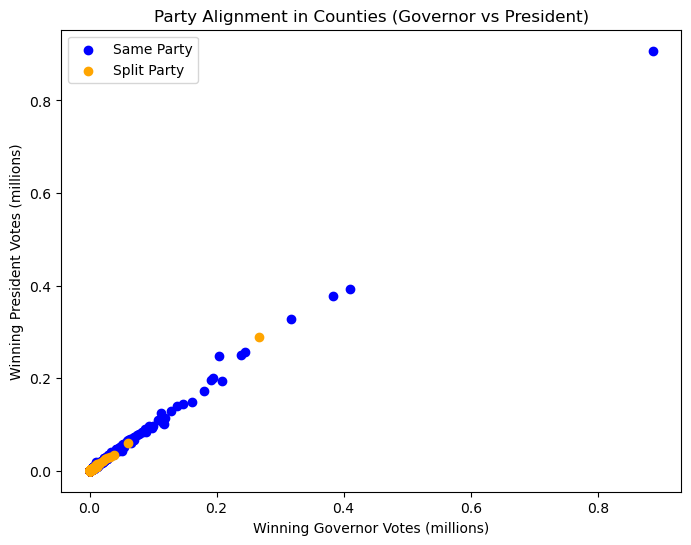

['Delaware' 'Indiana' 'Missouri' 'Montana' 'New Hampshire'
 'North Carolina' 'North Dakota' 'Utah' 'Vermont' 'Washington'
 'West Virginia']


In [ ]:
gov_by_county = clean_gov_df.groupby(['state', 'county'], as_index=False)['votes'].sum()
pres_by_county = clean_pres_df.groupby(['state', 'county'], as_index=False)['votes'].sum() #grouping the data makes state and county indexes unless we use as_index = false

gov_winners = clean_gov_df[clean_gov_df['won']].copy()
pres_winners = clean_pres_df[clean_pres_df['won']].copy()

merged_data = gov_winners.merge(
    pres_winners,
    on=['state', 'county'],
    suffixes=('_gov', '_pres')
)

merged_data['party_eq'] = merged_data['party_gov'] == merged_data['party_pres']

plt.figure(figsize=(8,6))


same_party = merged_data[merged_data['party_eq'] == True]
plt.scatter(
    same_party['votes_gov']/1000000,
    same_party['votes_pres']/1000000,
    color='blue',
    label='Same Party'
)

# Split party
split_party = merged_data[merged_data['party_eq'] == False]
plt.scatter(
    split_party['votes_gov']/1000000,
    split_party['votes_pres']/1000000,
    color='orange',
    label='Split Party'
)

plt.xlabel("Winning Governor Votes (millions)")
plt.ylabel("Winning President Votes (millions)")
plt.title("Party Alignment in Counties (Governor vs President)")
plt.legend()
plt.show()



Descriptive Statistics

In [ ]:
desc_stats = merged_data[['votes_gov', 'votes_pres']].describe()
print(desc_stats)

print(same_party["state"].unique()) #the county that contains seattle looks like a big outlier because the dataset doesn't have a comparable state/county
print(split_party["state"].unique())

print(split_party.sort_values(by="votes_gov", ascending=False)) #Salt Lake County is the outlier in the split party data

           votes_gov     votes_pres
count    1025.000000    1025.000000
mean    12487.689756   12695.991220
std     42228.752855   42922.320095
min         4.000000       5.000000
25%       742.000000     682.000000
50%      2663.000000    2575.000000
75%      9076.000000    9573.000000
max    887374.000000  907310.000000
['Delaware' 'Indiana' 'Missouri' 'Montana' 'New Hampshire'
 'North Carolina' 'North Dakota' 'Utah' 'Vermont' 'Washington'
 'West Virginia']
['Indiana' 'Montana' 'New Hampshire' 'North Carolina' 'Utah' 'Vermont'
 'Washington']
             state             county candidate_gov party_gov  votes_gov  \
673           Utah   Salt Lake County   Spencer Cox       REP     266177   
73         Indiana  St. Joseph County  Eric Holcomb       REP      60696   
81         Indiana  Tippecanoe County  Eric Holcomb       REP      37979   
396  New Hampshire         Manchester  Chris Sununu       REP      32454   
401  New Hampshire             Nashua  Chris Sununu       REP      267